# Import Module

In [74]:
import csv
import time
import sys
import os
import random

# other library
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PyTorch library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from tqdm.notebook import tqdm

# Fix random seed

In [75]:
SEED = 5566 # Do not modify
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Dataset Download:

In [76]:
!gdown --id "1Rlt_mU-siC6AayAjNMXZ8N8fURWg5iLB" --output "trainX.npy"
!gdown --id "1v7i5rP2UQv_2ju8akh69M5VzEjRJV3tB" --output "visualization_X.npy"


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Rlt_mU-siC6AayAjNMXZ8N8fURWg5iLB
To: /content/trainX.npy
100% 221M/221M [00:01<00:00, 166MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1v7i5rP2UQv_2ju8akh69M5VzEjRJV3tB
To: /content/visualization_X.npy
100% 15.4M/15.4M [00:00<00:00, 258MB/s]


# Set Hyper-parameters

In [77]:
#TODO: Modified the hyper-parameter
NUM_EPOCH = 7
BATCH_SIZE = 32
LATENT_DIM = 24
REDUCED_DIM = 6
NUM_ITER = 1000
REDUCED_METHOD = 'pca' # or 'tsne'
lr = 5e-4

In [78]:
MODEL_NAME = 'model.pth'
DATA_PATH = 'trainX.npy'

# Define Dataset

In [79]:
from torchvision.transforms import v2
class Dataset(data.Dataset):
    def __init__(self, data_path):
        self.total_img = torch.from_numpy(np.load(data_path)).float()
        self.total_img = self.total_img.permute(0, 3, 1, 2)
        self.total_img = self.total_img/255

    def normalize(self, img):
        # TODO: normalize the dataset
        img = np.array(img)
        if img.std() == 0:
          return torch.tensor(img)
        else:
          img = (img-img.mean())/img.std()
          return torch.tensor(img)

    def augment(self, img):
        jitter = v2.ColorJitter(brightness=.5, hue=.3)
        img = jitter(img)
        return img

    def __len__(self):
        return len(self.total_img)

    def __getitem__(self, index):
        img = self.total_img[index]
        img_aug = self.augment(img)

        img_aug = self.normalize(img_aug)
        img = self.normalize(img)
        return img_aug, img

# Define Model Architerchure

**Please finish this block to run this code!**


In [80]:
class Net(nn.Module):
    def __init__(self, image_channels=3, latent_dim=128):
        super(Net, self).__init__()
        self.latent_dim = latent_dim
        self.img_size = 32

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            # TODO: define your own structure
        )

        # TODO: check the dimension if you modified the structure
        self.fc1 = nn.Linear(32*8*8, self.latent_dim)

        # TODO: check the dimension if you modified the structure
        self.fc2 = nn.Linear(self.latent_dim, 32*8*8)

        self.decoder = nn.Sequential(
           # TODO: define yout own structure
           # Hint: nn.ConvTranspose2d(...)
           nn.ConvTranspose2d(32, 128, kernel_size=4, stride=2, padding=1),
           nn.ReLU(),
           nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x):

        feature_map = self.encoder(x)
        latent_vec = self.fc1(feature_map.reshape(feature_map.shape[0], -1))
        feature_map2 = self.fc2(latent_vec)
        f = feature_map2.view(-1,32,8,8)
        x_res = self.decoder(f)

        return latent_vec, x_res

# Define Training Process

In [81]:
def training(train, val, model, device, n_epoch, batch, save_name, lr):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('=== start training, parameter total:%d, trainable:%d' % (total, trainable))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                             weight_decay=1e-5)
    best_loss = 100
    for epoch in range(n_epoch):
        total_loss = 0

        # training set
        model.train()
        idx = 0
        for image_aug, image in tqdm(train):
            image = image.to(device, dtype=torch.float)
            image_aug = image_aug.to(device, dtype=torch.float)
            _, reconsturct = model(image_aug)
            loss = criterion(reconsturct, image)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += (loss.item() / len(train))

            print('[Epoch %d | %d/%d] loss: %.4f' %
                 ((epoch+1), idx*batch, len(train)*batch, loss.item()), end='\r')
            idx += 1
        print("\n  Training  | Loss:%.4f " % total_loss)

        # validation set
        model.eval()
        total_loss = 0
        idx = 0
        with torch.no_grad():
            for image_aug, image in tqdm(val):
                image = image.to(device, dtype=torch.float)
                image_aug = image_aug.to(device, dtype=torch.float)
                _, reconstruct = model(image_aug)

                loss = criterion(reconstruct, image)
                total_loss += (loss.item() / len(val))
                idx += 1
            print(" Validation | Loss:%.4f " % total_loss)
        # save model
        if total_loss < best_loss:
                best_loss = total_loss
                print("saving model with loss %.4f...\n" % total_loss)
                torch.save(model.state_dict(), "%s" % save_name)

# Define Clustering Process

In [82]:
def clustering(model, device, loader, n_iter, reduced_method, reduced_dim, perplexity):
    assert reduced_method in ['pca', 'tsne', None]

    model.eval()
    latent_vec = torch.tensor([]).to(device, dtype=torch.float)
    for idx, (image_aug, image) in enumerate(loader):
        print("predict %d / %d" % (idx, len(loader)) , end='\r')
        image = image.to(device, dtype=torch.float)
        latent, r = model(image)
        latent_vec = torch.cat((latent_vec, latent), dim=0)

    latent_vec = latent_vec.cpu().detach().numpy()

    if reduced_method == 'tsne':
        tsne = TSNE(n_components=reduced_dim, verbose=1, method='exact', perplexity=perplexity, n_iter=n_iter, n_iter_without_progress = 50, learning_rate = 50)
        latent_vec = tsne.fit_transform(latent_vec)
    elif reduced_method == 'pca':
        pca = PCA(n_components=reduced_dim, copy=False, whiten=True, svd_solver='full')
        latent_vec = pca.fit_transform(latent_vec)

    kmeans = KMeans(n_clusters=2, random_state=0, max_iter=n_iter).fit(latent_vec)
    return kmeans.labels_

# Define write function

In [83]:
def write_output(predict_result, file_name='predict.csv'):
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for i in range(len(predict_result)):
            writer.writerow([str(i), str(predict_result[i])])

# Main Process

In [84]:
# build dataset
dataset = Dataset(DATA_PATH)
print(len(dataset))

# Random split
train_set_size = int(len(dataset) * 0.85)
valid_set_size = len(dataset) - train_set_size
train_set, valid_set = data.random_split(dataset, [train_set_size, valid_set_size])

# set data loader
train_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=1, shuffle=True)
valid_loader = data.DataLoader(valid_set, batch_size=BATCH_SIZE, num_workers=1, shuffle=False)

model = Net(latent_dim=LATENT_DIM).to(device)
print(model)
training(train_loader, valid_loader, model, device, NUM_EPOCH, BATCH_SIZE, MODEL_NAME, lr)



9000
Net(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (fc1): Linear(in_features=2048, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=2048, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)
=== start training, parameter total:212667, trainable:212667


  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 1 | 7648/7680] loss: 0.3366
  Training  | Loss:0.4825 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.3738 
saving model with loss 0.3738...



  0%|          | 0/240 [00:00<?, ?it/s]


  Training  | Loss:0.3503 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.3560 
saving model with loss 0.3560...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 3 | 7648/7680] loss: 0.1242
  Training  | Loss:0.3359 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.3415 
saving model with loss 0.3415...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 4 | 7648/7680] loss: 0.3416
  Training  | Loss:0.3286 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.3343 
saving model with loss 0.3343...



  0%|          | 0/240 [00:00<?, ?it/s]


  Training  | Loss:0.3260 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.3372 


  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 6 | 7648/7680] loss: 0.1773
  Training  | Loss:0.3229 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.3274 
saving model with loss 0.3274...



  0%|          | 0/240 [00:00<?, ?it/s]

[Epoch 7 | 7648/7680] loss: 0.2991
  Training  | Loss:0.3210 


  0%|          | 0/43 [00:00<?, ?it/s]

 Validation | Loss:0.3277 


# Inference

In [85]:
test_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
model.load_state_dict(torch.load(MODEL_NAME))
predicted = clustering(model, device, test_loader, NUM_ITER, reduced_method=REDUCED_METHOD, reduced_dim=REDUCED_DIM, perplexity=15)
if predicted[0] == 1:
  for i in range(len(predicted)):
    if predicted[i] == 0:
      predicted[i] = 1
    elif predicted[i] == 1:
      predicted[i] = 0
print(predicted)
write_output(predicted, 'pred.csv')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 1 0 ... 0 1 0]


### Report 2


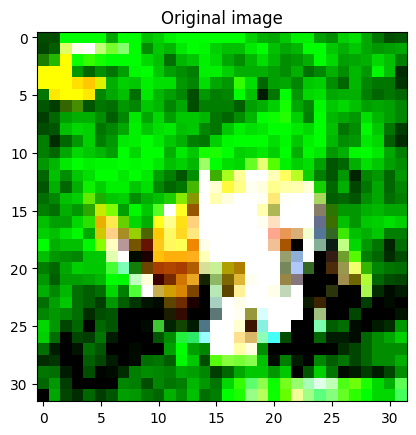

The error is: 
tensor(0.5516, grad_fn=<MseLossBackward0>) 



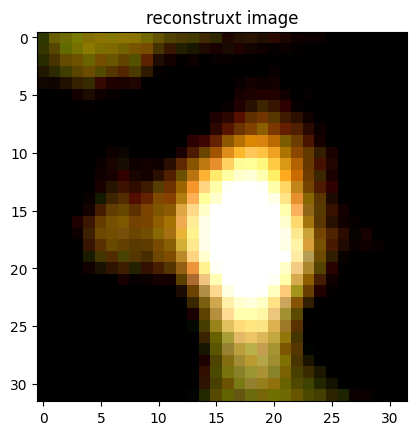

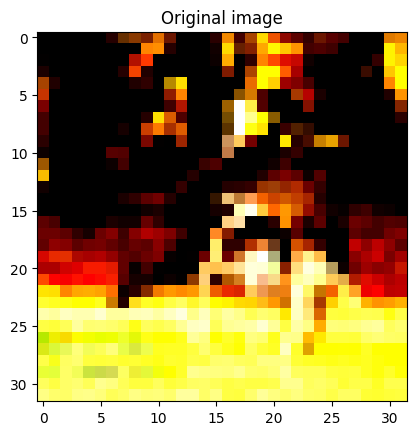

The error is: 
tensor(0.2425, grad_fn=<MseLossBackward0>) 



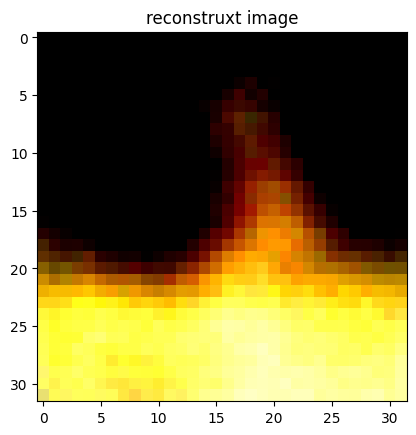

In [86]:
import matplotlib.pyplot as plt
criterion = nn.MSELoss()
model.eval()
latent_vec = torch.tensor([]).to(device, dtype=torch.float)
for idx, (image_aug, image) in enumerate(test_loader):
  if idx >=2:
    break
  print("predict %d / %d" % (idx, len(test_loader)) , end='\r')
  image = image.to(device, dtype=torch.float)
  latent, r = model(image)
  loss = criterion(r[0], image[0])

  image_array = image[0].detach().numpy().transpose(1, 2, 0)
  r_array = r[0].detach().numpy().transpose(1, 2, 0)
  plt.subplot(1, 1, 1)
  plt.imshow(image_array)  # Transpose to (84, 84, 3) for displaying RGB images
  plt.title('Original image')
  plt.show()

  print("The error is: ")
  print(loss,"\n")
  plt.imshow(r_array)
  plt.title('reconstruxt image')
  plt.show()


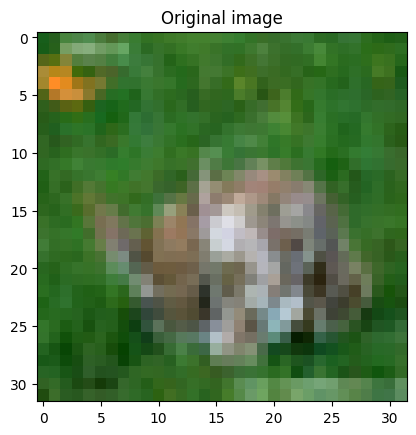

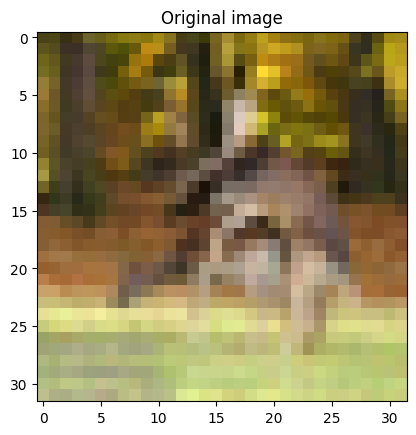

In [87]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming you have a torch tensor with shape [3, 32, 32]
images = torch.from_numpy(np.load(DATA_PATH)).float()
images = images.permute(0, 3, 1, 2)  # Assuming channels are in the last dimension

# Display the first two images
count = 0
for a in images:
  if count == 32 or count == 0:
    r_array = a.numpy()

    # Normalize the data to [0, 1]
    norm = mcolors.Normalize(vmin=r_array.min(), vmax=r_array.max())
    r_array = norm(r_array)

    plt.imshow(r_array.transpose(1, 2, 0))
    plt.title('Original image')
    plt.show()
  count +=1


### Report 3

In [88]:
visualset = Dataset('visualization_X.npy')
visual_loader = data.DataLoader(visualset, batch_size=BATCH_SIZE, shuffle=False)

In [89]:
model.eval()
latent_vec = torch.tensor([]).to(device, dtype=torch.float)
for idx, (image_aug, image) in enumerate(visual_loader):
    print("predict %d / %d" % (idx, len(visual_loader)) , end='\r')
    image = image.to(device, dtype=torch.float)
    latent, r = model(image)
    latent_vec = torch.cat((latent_vec, latent), dim=0)
pca = PCA(n_components=2, copy=False, whiten=True, svd_solver='full')

In [90]:
latent_vec = latent_vec.cpu().detach().numpy()
pca = PCA(n_components=2, copy=False, whiten=True, svd_solver='full')
pca_vec = pca.fit_transform(latent_vec)

In [91]:
tsne = TSNE(n_components=2, verbose=1, method='exact', perplexity=15, n_iter=NUM_ITER, n_iter_without_progress = 50)
tsne_vec = tsne.fit_transform(latent_vec)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.229970
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.542661
[t-SNE] KL divergence after 1000 iterations: 2.170424


In [93]:
pcavec1 = pca_vec[:2500]
pcavec2 = pca_vec[2500:]
print(len(pcavec1))
print(len(pcavec2))

2500
2500


In [94]:
tsnevec1 = tsne_vec[:2500]
tsnevec2 = tsne_vec[2500:]

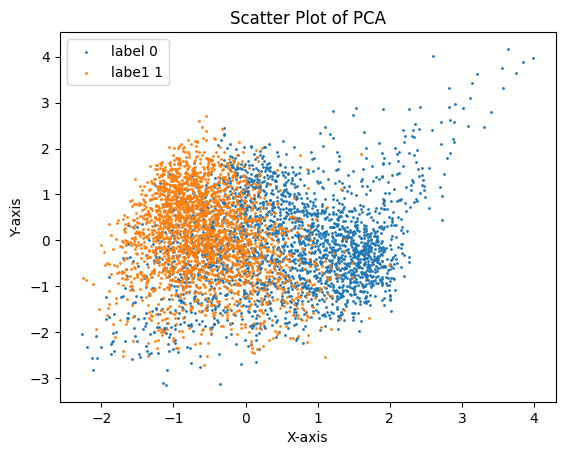

In [95]:

plt.scatter(pcavec1[:, 0], pcavec1[:, 1], label='label 0', s=1)  # 's' is the marker size
plt.scatter(pcavec2[:, 0], pcavec2[:, 1], label='labe1 1', s=1)

# Plotting points from array2
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of PCA')

# Adding legend
plt.legend()

# Display the plot
plt.show()

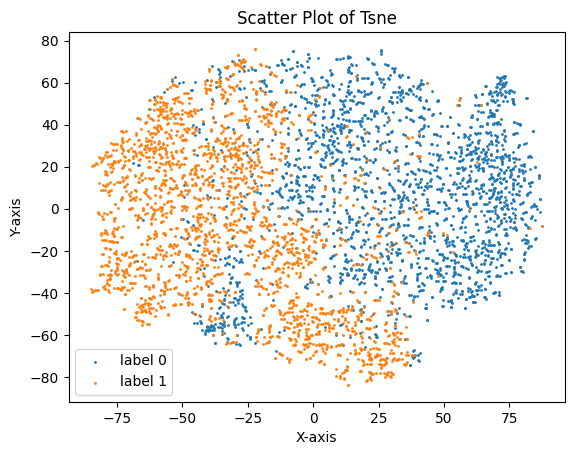

In [96]:
plt.scatter(tsnevec1[:, 0], tsnevec1[:, 1], label='label 0', s=1)  # 's' is the marker size
plt.scatter(tsnevec2[:, 0], tsnevec2[:, 1], label='label 1', s=1)
# Plotting points from array2
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of Tsne')

# Adding legend
plt.legend()

# Display the plot
plt.show()